# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

from maddpg_agent import Agent
import torch
from collections import deque
from matplotlib import pyplot as plt
import time

The device to use:  cuda:0


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Train the agents with DDPG



Initializing ReplayBuffer
Agent 0 appended to Agent.instances
Agent 1 appended to Agent.instances
Episode 100	Average Score: 0.00
Episode 200	Average Score: 0.05
Episode 300	Average Score: 0.12
Episode 400	Average Score: 0.19
Episode 473	Score: [ 0.90  0.89]	Average Score: 0.51 (8.9 secs)
Environment solved in 373 episodes!	Average Score: 0.51


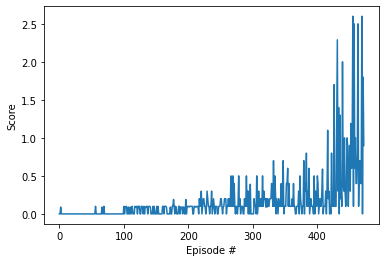

In [5]:
def ddpg(n_episodes=2000, max_t=1000):
    """ Deep Deterministic Policy Gradients
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    scores_window = deque(maxlen=100)
    scores = np.zeros(num_agents)
    scores = []
    
    agents =[] 
    
    # amplitude of OU noise starts from 2, slowly decreases to 0
    noise = 2
    noise_reduction = 0.9999
    
    for i in range(num_agents):
        agents.append(Agent(state_size, action_size, random_seed=0)) # initialize agents
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        for agent in agents:
            agent.reset()
            
        score = np.zeros(num_agents)
            
        start_time = time.time()
        for t in range(max_t):  
            actions = np.array([agents[i].act(states[i],noise) for i in range(num_agents)])
            noise *= noise_reduction

            env_info = env.step(actions)[brain_name]       # send the action to the environment
            next_states = env_info.vector_observations     # get the next state
            rewards = env_info.rewards                     # get the reward
            dones = env_info.local_done  
            score += rewards      
            
            for i in range(num_agents):
                agents[i].step(states[i], actions[i], rewards[i], next_states[i], dones[i], t) 
 
            states = next_states
            
            if np.any(dones):
                break
            
        end_time = time.time()    
        score_max = np.max(score)
        scores_window.append(score_max)       # save scores in recent 100 episodes
        scores.append(score_max)              # save scores for all episodes

        print('\rEpisode {}\tScore: {}\tAverage Score: {:.2f} ({:.1f} secs)'.format(i_episode, score, np.mean(scores_window), end_time-start_time), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(Agent.instances[0].actor_local.state_dict(), 'checkpoint_actor0.pth')
            torch.save(Agent.instances[1].actor_local.state_dict(), 'checkpoint_actor1.pth')
            torch.save(Agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            return scores
            
    return scores

# 2 agents for the Tennis environment
assert num_agents == 2
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
    
scores = ddpg()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [6]:
env.close()